<a href="https://colab.research.google.com/github/edmanft/Drug_Synergy/blob/main/Adding%20drug%20information.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instead of just providing drug names, cell line names and monotherapy information, now we also give specific information about drugs:

'Function_drug_A', 'Pathway_drug_A', Function_drug_B', 'Pathway_drug_B'.






# Loading packages

In [1]:
!pip install fastai --upgrade
!pip install dtreeviz
!pip install fastbook

     |████████████████████████████████| 189 kB 14.4 MB/s 
     |████████████████████████████████| 55 kB 2.5 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 61 kB 189 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.5-py3-none-any.whl size=67330 sha256=11c5f9234ead05cdc9778dede4c8eb8bbeb7ce00404d46baacb946ce86be2cd1
  Stored in directory: /root/.cache/pip/wheels/9d/84/55/4de0a214e0b9d21a96fc343b4a85547f3dab815a49682dfeb2
Successfully built dtreeviz
     |████████████████████████████████| 720 kB 10.1 MB/s 
     |████████████████████████████████| 1.2 MB 15.2 MB/s 
     |████████████████████████████████| 48 kB 4.1 MB/s 
     |████████████████████████████████| 561 kB 57.8 MB/s 
     |████████████████████████████████| 51 kB 233 kB/s 
     |████████████████████████████████| 130 kB 57.5 MB/s 
  Attempting uninstall: jupyter-client
   

In [2]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
from fastbook import *

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from collections import Counter
import seaborn as sns
import xgboost
from xgboost import XGBRegressor

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Loading Data 1

In [4]:
path = "/content/gdrive/MyDrive/archivos_tfm/drug_comb_drug_info.csv"

df_drug_comb = pd.read_csv(path, index_col = 0)


In [5]:
df_drug_comb.head(10)

,Cell line name,Compound A,Compound B,Max. conc. A,...,Function_drug_A,Pathway_drug_A,Function_drug_B,Pathway_drug_B
0,BT-20,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
1,CAL-120,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
2,CAL-51,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
3,DU-4475,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
4,HCC1143,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
5,HCC1187,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
6,HCC1428,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
7,HCC1806,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
8,HCC1937,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
9,HCC70,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration


In [6]:
df_drug_comb.columns


Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'QA', 'Combination ID', 'Challenge', 'Dataset',
       'Function_drug_A', 'Pathway_drug_A', 'Function_drug_B',
       'Pathway_drug_B'],
      dtype='object')

In [7]:
print("Splits: ",df_drug_comb['Dataset'].unique())
print("Challenge: ",df_drug_comb['Challenge'].unique())

Splits:  ['train' 'LB' 'test']
Challenge:  ['ch1']


In this dataset we have a train/test/Leaderboard split. Also, all of our data refers to challege 1, so we can just drop that column later.

In [8]:
# A little bit of data analysis
df_drug_comb.describe()

,Max. conc. A,Max. conc. B,IC50 A,H A,...,H B,Einf B,Synergy score,QA
count,3879.000000,3879.000000,3879.000000,3879.000000,...,3879.000000,3879.000000,3879.000000,3879.000000
mean,1.721684,4.960581,0.733284,2.900107,...,2.902762,48.091803,10.236308,0.758443
std,1.818286,14.657023,1.021671,3.634496,...,3.704492,35.876790,116.249064,0.742968
min,0.003000,0.003000,0.000003,0.000000,...,0.000000,0.000000,-588.220700,-3.000000
25%,1.000000,1.000000,0.069179,0.507272,...,0.432883,12.537512,-5.246305,1.000000
50%,1.000000,1.000000,0.337817,1.264897,...,1.177369,47.599717,8.429529,1.000000
75%,3.000000,3.000000,1.000000,2.989752,...,3.014471,82.398922,25.385300,1.000000
max,10.000000,75.000000,10.000000,10.000000,...,10.000000,100.000000,6737.175000,1.000000


We will choose to train only in high quality data, meaning QA=1.

In [9]:
df_drug_comb = df_drug_comb[df_drug_comb["QA"] == 1]
print("Values of QA:", df_drug_comb["QA"].unique())

Values of QA: [1]


We drop QA, Combination ID and Challenge.

In [10]:
df_drug_comb.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'QA', 'Combination ID', 'Challenge', 'Dataset',
       'Function_drug_A', 'Pathway_drug_A', 'Function_drug_B',
       'Pathway_drug_B'],
      dtype='object')

In [11]:
df_drug_comb.drop(['QA','Challenge'], axis = 1, inplace = True)

SettingWithCopyError: ignored

It gives a warning but it has succesfully dropped QA and Challenge columns from the DataFrame.

# Loading Data 2

In [12]:
df_drug_comb.head()

,Cell line name,Compound A,Compound B,Max. conc. A,...,Function_drug_A,Pathway_drug_A,Function_drug_B,Pathway_drug_B
0,BT-20,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
2,CAL-51,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
5,HCC1187,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
7,HCC1806,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
8,HCC1937,AKT,ADAM17,1.0,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration


In [13]:
df_drug_comb.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'Combination ID', 'Dataset', 'Function_drug_A',
       'Pathway_drug_A', 'Function_drug_B', 'Pathway_drug_B'],
      dtype='object')

In [14]:
dep_var = 'Synergy score'
procs = [Categorify, FillMissing]


In [15]:
# We shuffle the data
df_drug_comb = df_drug_comb.sample(frac=1).reset_index(drop=True)
df_drug_comb.head(10)

,Cell line name,Compound A,Compound B,Max. conc. A,...,Function_drug_A,Pathway_drug_A,Function_drug_B,Pathway_drug_B
0,HCC1143,FGFR,EGFR,1.00,...,Oncogenic signal,RTK,Oncogenic signal,RTK
1,MDA-MB-468,PIK3C,AKT_1,3.00,...,Oncogenic signal,AKT/PI3K,Oncogenic signal,AKT/PI3K
2,MFM-223,MAP2K_1,ATR_4,1.00,...,Oncogenic signal,MAPK,DNA repair,DNA Damage Response
3,BT-20,MTOR_1,FASN,1.00,...,Oncogenic signal,AKT/PI3K,Metabolism,Metabolism
4,SW948,IGFR_3,IAP,10.00,...,Oncogenic signal,RTK,Cell death,Apoptosis
5,MDA-MB-453,MTOR_1,ADAM17,1.00,...,Oncogenic signal,AKT/PI3K,Differentiation,EMT/migration
6,NCI-H838,CarboTaxol,BCL2,0.01,...,DNA repair,Chemo,Cell death,Apoptosis
7,SW900,TOP2,ALK_2,3.00,...,DNA repair,DNA Damage Response,Oncogenic signal,RTK
8,MDA-MB-361,MTOR_3,FGFR,1.00,...,Oncogenic signal,AKT/PI3K,Oncogenic signal,RTK
9,HCC1937,PIK3CA_4,MTOR_1,1.00,...,Oncogenic signal,AKT/PI3K,Oncogenic signal,AKT/PI3K


We create the train/test/LB splits and then create a copy of our dataset without the Combination ID. 
We want to retain the Combination ID because we use it for our Weighted Pearson metric.

In [16]:
dataset_size = df_drug_comb.shape[0]
complete_list = np.arange(dataset_size, dtype = int)

train_idx = complete_list[df_drug_comb["Dataset"]=="train"]
test_idx = complete_list[df_drug_comb["Dataset"]=="test"]
LB_idx = complete_list[df_drug_comb["Dataset"]=="LB"]

# For now we ignore the LB split

splits = (list(train_idx),list(test_idx))

df_drug_comb.drop(['Dataset'], axis = 1, inplace = True)
df_nocomb = df_drug_comb.drop(['Combination ID'], axis = 1)


In [17]:
print("With Combination ID: ", df_drug_comb.columns)
print("Without Combination ID:", df_nocomb.columns )

With Combination ID:  Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'Combination ID', 'Function_drug_A', 'Pathway_drug_A',
       'Function_drug_B', 'Pathway_drug_B'],
      dtype='object')
Without Combination ID: Index(['Cell line name', 'Compound A', 'Compound B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B',
       'Synergy score', 'Function_drug_A', 'Pathway_drug_A', 'Function_drug_B',
       'Pathway_drug_B'],
      dtype='object')


In [18]:
cont,cat = cont_cat_split(df_nocomb, 1, dep_var=dep_var)
to = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, splits=splits)

In [19]:
len(to.train),len(to.valid)

(1795, 1089)

In [20]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

### Understanding xs, ym valid_xs, valid_y

In [26]:
xs.columns

Index(['Cell line name', 'Compound A', 'Compound B', 'Function_drug_A',
       'Pathway_drug_A', 'Function_drug_B', 'Pathway_drug_B', 'Max. conc. A',
       'Max. conc. B', 'IC50 A', 'H A', 'Einf A', 'IC50 B', 'H B', 'Einf B'],
      dtype='object')

In [27]:
xs.head(10)

,Cell line name,Compound A,Compound B,Function_drug_A,...,Einf A,IC50 B,H B,Einf B
1,50,32,3,5,...,0.000000,0.327204,10.000000,69.899765
2,51,25,9,5,...,100.000000,0.368849,10.000000,75.098839
5,49,28,1,5,...,14.599023,1.000000,0.000000,100.000000
7,77,50,6,2,...,61.816383,2.149279,0.731725,0.000000
9,27,34,41,5,...,86.199829,1.000000,0.900497,50.879997
11,10,37,3,5,...,45.571762,0.261342,1.071766,0.000000
12,26,49,31,5,...,1.733648,0.011699,10.000000,94.774933
13,9,18,4,5,...,48.294754,0.125689,1.222968,74.233620
14,27,49,41,5,...,47.170940,1.000000,0.929727,59.556419
15,20,28,39,5,...,10.386720,0.013501,1.144306,49.805904


It converts categorical variables into numerical ones. 

In [28]:
to.classes["Compound A"]

['#na#', 'AKT', 'AKT_1', 'ALK_IGFR', 'ATR_4', 'BCL2L1', 'BCL2_2', 'BCL2_BCL2L1', 'CSNK2A1_2', 'CarboTaxol', 'Chloroquine', 'Cisplatin', 'EGFR', 'EGFR_2', 'ERBB', 'ESR1', 'ESR1_1', 'FASN', 'FGFR', 'Gemcitabine', 'HDAC_4', 'IAP', 'IGFR_3', 'IGFR_4', 'JAK', 'MAP2K_1', 'MAP2K_3', 'MTOR', 'MTOR_1', 'MTOR_3', 'Oxaliplatin', 'PARP1', 'PIK3C', 'PIK3CA_3', 'PIK3CA_4', 'PIK3CB', 'PIK3CB_PIK3CD', 'PIK3C_2', 'PIK3C_MTOR', 'PIM1', 'PIP5K1', 'PTK2', 'Proteasome_2', 'SLC16A4', 'SN38', 'SYK', 'TKI', 'TNF', 'TNFSF10', 'TNKS_PARP6', 'TOP2', 'TOP2_2', 'Topotecan', 'Vinorelbine', 'WNT']

In [29]:
df_nocomb["Compound A"].unique()

array(['FGFR', 'PIK3C', 'MAP2K_1', 'MTOR_1', 'IGFR_3', 'CarboTaxol', 'TOP2', 'MTOR_3', 'PIK3CA_4', 'PIK3CB', 'PIK3C_2', 'TNKS_PARP6', 'EGFR', 'SLC16A4', 'ALK_IGFR', 'PIP5K1', 'JAK', 'PIK3CA_3',
       'Topotecan', 'PTK2', 'PIM1', 'TNF', 'PIK3CB_PIK3CD', 'IAP', 'CSNK2A1_2', 'PARP1', 'Gemcitabine', 'AKT_1', 'Cisplatin', 'Vinorelbine', 'ESR1_1', 'HDAC_4', 'ERBB', 'BCL2_BCL2L1', 'TNFSF10',
       'EGFR_2', 'ATR_4', 'WNT', 'IGFR_4', 'MAP2K_3', 'FASN', 'SN38', 'Oxaliplatin', 'TOP2_2', 'Proteasome_2', 'Chloroquine', 'PIK3C_MTOR', 'BCL2_2', 'BCL2L1', 'TKI', 'AKT', 'ESR1', 'MTOR', 'SYK'],
      dtype=object)

When we do to.classes there appears a "#na#" item that does not appear in the original DataFrame. Ask Pablo about that.

In [30]:
y

1       24.378630
2      -19.085140
5      -11.081940
7      -21.021490
9        3.537330
          ...    
3468   -23.168930
3470    -1.023761
3471    12.894160
3472    19.809669
3473    47.096230
Name: Synergy score, Length: 1795, dtype: float32

# Baseline model: mean and median

  Let's see how good it performs a model whose only information is the mean or the median of the train set.

In [31]:
mean = np.mean(y)
median = np.median(y)
print(f" Median = {median} \n Mean = {mean}")

 Median = 9.755132675170898 
 Mean = 12.747149467468262


We create our metrics

In [32]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [33]:
error_mean = r_mse(mean, valid_y)
error_median = r_mse(median, valid_y)
print(f" Error Median = {error_median} \n Error Mean = {error_mean}")

 Error Median = 28.020176 
 Error Mean = 27.897857


However, we now know that the correct metric is going to be a weighted Pearson correlation coefficient, which takes into account the number of cell lines used per drug pair experiment. It will give 0 for uncorrelated data.

What we want to measure is if the experimental and predicted synergy scores are correlated for every drug pair.

In [34]:
def weighted_pearson(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        rho_list.append(pearson[0,1])
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*pearson[0,1]
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    pear_weights_df = pd.DataFrame({"Combination ID" : id_list ,
                                    "n_cl" : list(cl_count.values()),
                                "Pearson coefficient" : rho_list })
    
    return weighted_pear, pear_weights_df

We make a function that accounts for possible values of nan's in the dataset and sets them to 0.


In [35]:
def nan_weighted_pearson(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination, 
    setting nan's to 0.
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        if np.isnan(pearson[0,1]):
          rho_i = 0
        else: 
          rho_i = pearson[0,1]
        rho_list.append(rho_i)
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*rho_i
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    pear_weights_df = pd.DataFrame({"Combination ID" : id_list ,
                                    "n_cl" : list(cl_count.values()),
                                "Pearson coefficient" : rho_list })
    
    return weighted_pear, pear_weights_df

And one that only gives metric for fast training:

In [36]:
def wpc_score(df_dc_test, y_pred):
    
    
    """
    Computes the weighted Pearson correlation coefficient and a DataFrame of
    the individual Pearson coefficients of each combination, 
    setting nan's to 0.
    
    INPUTS:
    df_dc_test: dataset used for inference. We only use the combination
                    id and the observed synergy.
    y_pred: predictions of the model"""

    y_obs = np.asarray(df_dc_test["Synergy score"])
    
    cl_count = Counter(df_dc_test["Combination ID"])

    id_list = list(cl_count.keys())

    rho_list = list()
    
    numerator = 0
    denominator = 0


    for ids in id_list:
        
        "We compute the appropiate mask, since combinations are not"
        "grouped in the dataset"
        condition = df_dc_test["Combination ID"] == ids
        
        pearson = np.corrcoef(y_pred[condition], y_obs[condition])
        "pearson is a correlation matrix, we want an off-diagonal term"
        if np.isnan(pearson[0,1]):
          rho_i = 0
        else: 
          rho_i = pearson[0,1]
        
        
        "Number of times each drug combination appears"
        rep =  np.sum(condition)
        
       
        "np.sqrt(rep-1) is the relative weight of the drug pair"
        
        numerator = numerator + np.sqrt(rep-1)*rho_i
        denominator = denominator + np.sqrt(rep-1)
        
    weighted_pear = numerator / denominator
    
    
    
    return weighted_pear

In [37]:
test_df = df_drug_comb.iloc[test_idx]
test_df

,Cell line name,Compound A,Compound B,Max. conc. A,...,Function_drug_A,Pathway_drug_A,Function_drug_B,Pathway_drug_B
0,HCC1143,FGFR,EGFR,1.0,...,Oncogenic signal,RTK,Oncogenic signal,RTK
3,BT-20,MTOR_1,FASN,1.0,...,Oncogenic signal,AKT/PI3K,Metabolism,Metabolism
4,SW948,IGFR_3,IAP,10.0,...,Oncogenic signal,RTK,Cell death,Apoptosis
8,MDA-MB-361,MTOR_3,FGFR,1.0,...,Oncogenic signal,AKT/PI3K,Oncogenic signal,RTK
10,NCI-H1437,PIK3CB,IAP,3.0,...,Oncogenic signal,AKT/PI3K,Cell death,Apoptosis
...,...,...,...,...,...,...,...,...,...
3459,HCC1806,MTOR_1,FASN,1.0,...,Oncogenic signal,AKT/PI3K,Metabolism,Metabolism
3460,RKO,TKI,MAP2K_1,3.0,...,Oncogenic signal,RTK,Oncogenic signal,MAPK
3461,CAL-120,TNKS_PARP6,PIK3CB_PIK3CD,1.0,...,Oncogenic signal,Cell Cycle,Oncogenic signal,AKT/PI3K
3469,NCI-H1975,TOP2_2,IAP,3.0,...,DNA repair,Chemo,Cell death,Apoptosis


**Sanity check:** we try the metric by predicting values around the mean of the synergy score of the train split. As this values are random, statistically they will be uncorrelated with the experimental values. We should obtain a weighted Pearson score close to 0.

In [38]:
n_exp = len(test_idx)
y_pred = np.ones(n_exp)* mean  + np.random.random(n_exp)*1000
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)

Weighted Pearson:  0.03331663603851773


It's very small and oscillates around 0. 




# Decision Trees


In [ ]:
# Now that we have preprocessed our dataset, we build the tree



Tree = DecisionTreeRegressor(max_leaf_nodes=4)
Tree.fit(xs, y);

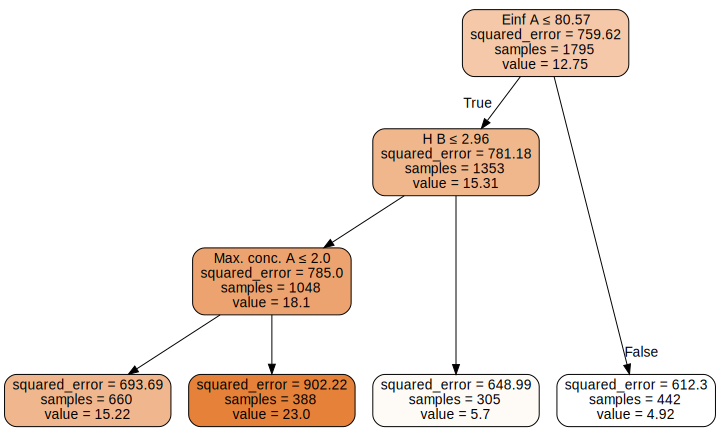

In [ ]:
draw_tree(Tree, xs, size=10, leaves_parallel=True, precision=2)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


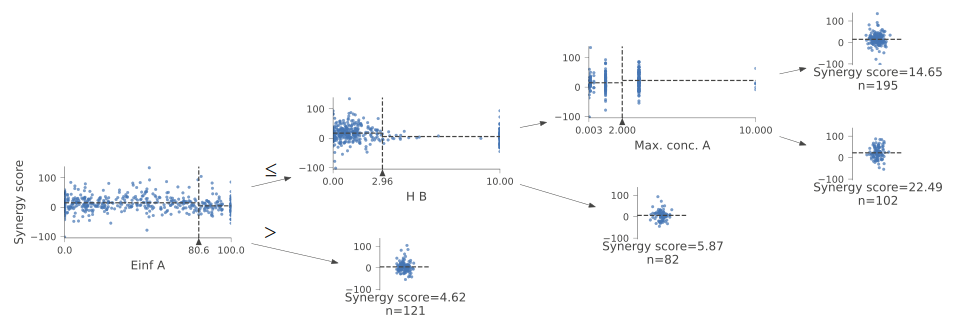

In [ ]:

samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(Tree, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as max_leaf_nodes:


In [ ]:
m = DecisionTreeRegressor()
m.fit(xs, y);


In [ ]:
# In the training set
m_rmse(m, xs, y)

0.0

This just means that the model fits well in the training dataset, but we have to check how well it generalizes over unseen data:

In [ ]:
m_rmse(m, valid_xs, valid_y)


36.81299

Now we will check for overfitting:

In [ ]:
m.get_n_leaves(), len(xs)

(1795, 1795)

We see that it has as many leafs as datapoints, let's see what happens if we restrict the model.

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(23.997595, 28.145969)

In [ ]:
m.get_n_leaves()


55

**The RMSE is almost the same as the baseline model. That's not good, let's try some hyperparameter tuning.**

In [ ]:
leafs = np.arange(500)+1
error_list = list()
for n_leafs in leafs:
  m = DecisionTreeRegressor(min_samples_leaf=n_leafs)
  m.fit(to.train.xs, to.train.y)
  error_list.append( m_rmse(m, valid_xs, valid_y) )

In [ ]:
error_list = np.asarray(error_list)
best_error = min(error_list)
best_leaf = leafs[error_list== min(error_list)][0]
print(f"Best number of leafs = {best_leaf} \n Error = {best_error}")

Best number of leafs = 152 
 Error = 27.38495


Let's check our metric

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf = best_leaf)
m.fit(to.train.xs, to.train.y)
y_pred = m.predict(valid_xs)
print(test_df.shape)
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)


(1089, 13)
Weighted Pearson:  nan
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.391300
1        FASN.MTOR_1     7            -0.124258
2         IAP.IGFR_3     3            -0.863058
3        FGFR.MTOR_3     5             0.560462
4         IAP.PIK3CB    10             0.462958
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.974069
163      HSP90.PIK3C     3             0.903799
164  ATM.Gemcitabine     3             0.279843
165     ATR_4.HDAC_4     3             0.982505
166   BCL2.CSNK2A1_2     6            -0.523300

[167 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


For some drug combination we obtain NaN's. My hypothesis is that for some drug pairs the predicted value is the same for all cell lines.

In [ ]:
check_nan = pear_weights_df["Pearson coefficient"].isnull()
combination_index = np.arange(pear_weights_df.shape[0], dtype = int)
nan_combinations = pear_weights_df.iloc[combination_index[check_nan]]
nan_combinations

,Combination ID,n_cl,Pearson coefficient
54,ALK.CSNK2A1_2,6,NaN
96,MTOR_1.TNKS_PARP6,7,NaN
133,Cisplatin.PIK3C,3,NaN
138,AKT.Cisplatin,3,NaN
148,AKT.Chloroquine,5,NaN
157,MTOR_1.SLC16A4,7,NaN


These are the drug combinations that have a NaN Pearson correlation. We pick the first one and check for the predicted values.

In [ ]:
nan_mask = test_df["Combination ID"] == "ALK.CSNK2A1_2"
ALK_CSNK2A1_2_df = test_df[nan_mask]
ALK_CSNK2A1_2_df

,Cell line name,Compound A,Compound B,Max. conc. A,...,H B,Einf B,Synergy score,Combination ID
217,NCI-H1563,CSNK2A1_2,ALK,0.03,...,1.831949,1.578234,5.147264,ALK.CSNK2A1_2
272,NCI-H522,CSNK2A1_2,ALK,0.03,...,1.652920,0.000000,-15.121200,ALK.CSNK2A1_2
1386,NCI-H2085,CSNK2A1_2,ALK,0.03,...,1.161107,0.000000,9.019851,ALK.CSNK2A1_2
1633,SW900,CSNK2A1_2,ALK,0.01,...,0.685584,0.000000,15.030920,ALK.CSNK2A1_2
3290,NCI-H2291,CSNK2A1_2,ALK,0.01,...,0.796128,0.000000,16.914830,ALK.CSNK2A1_2
3331,NCI-H838,CSNK2A1_2,ALK,0.10,...,1.619777,0.000000,16.545240,ALK.CSNK2A1_2


In [ ]:
y_pred_ALK_CSNK2A1_2 = y_pred[nan_mask]
y_pred_ALK_CSNK2A1_2

array([21.05977048, 21.05977048, 21.05977048, 21.05977048, 21.05977048, 21.05977048])

Just as I imagined. We are predicting the same values over and over. That's why our metric fails.

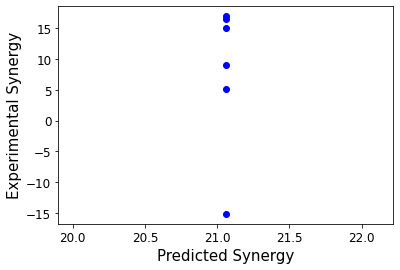

In [ ]:
plt.plot(y_pred_ALK_CSNK2A1_2 , ALK_CSNK2A1_2_df["Synergy score"] , "bo")
plt.ylabel("Experimental Synergy", fontsize = 15)
plt.xlabel("Predicted Synergy", fontsize = 15)
plt.savefig("predicted_experimental_synergy_decision_tree_nan.eps", format = 'eps', dpi=300)


Now with our metric function that takes nan's into account:


In [ ]:
weighted_pear, pear_weights_df = nan_weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.11147801629765684
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.391300
1        FASN.MTOR_1     7            -0.124258
2         IAP.IGFR_3     3            -0.863058
3        FGFR.MTOR_3     5             0.560462
4         IAP.PIK3CB    10             0.462958
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.974069
163      HSP90.PIK3C     3             0.903799
164  ATM.Gemcitabine     3             0.279843
165     ATR_4.HDAC_4     3             0.982505
166   BCL2.CSNK2A1_2     6            -0.523300

[167 rows x 3 columns]


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Just to make sure we check for the previous rows of pear_weights_df where there were nan's.

In [ ]:
nan_combinations = pear_weights_df.iloc[combination_index[check_nan]]
nan_combinations

,Combination ID,n_cl,Pearson coefficient
54,ALK.CSNK2A1_2,6,0.0
96,MTOR_1.TNKS_PARP6,7,0.0
133,Cisplatin.PIK3C,3,0.0
138,AKT.Cisplatin,3,0.0
148,AKT.Chloroquine,5,0.0
157,MTOR_1.SLC16A4,7,0.0


The function works.

# Random Forest

In [39]:
def rf(xs, y, n_estimators=100, max_samples=300,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, random_state = 42 ,oob_score=True).fit(xs, y)

In [40]:
m = rf(xs, y);
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)


(24.092626, 26.017886)

A little better than the Tree regressor, but not that great.

In [41]:
y_pred = m.predict(valid_xs)
weighted_pear, pear_weights_df = weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.1851296931848289
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.599587
1        FASN.MTOR_1     7             0.164464
2         IAP.IGFR_3     3             0.951853
3        FGFR.MTOR_3     5             0.804540
4         IAP.PIK3CB    10             0.425059
..               ...   ...                  ...
162   Cisplatin.FGFR     3            -0.762121
163      HSP90.PIK3C     3             0.335027
164  ATM.Gemcitabine     3            -0.363314
165     ATR_4.HDAC_4     3             0.995846
166   BCL2.CSNK2A1_2     6            -0.573368

[167 rows x 3 columns]


We see that Random Forest gives better prediction than Decision Trees. 

Let's try to obtain meaningful info. For example, let's order drug combinations from highest to lowest correlation

In [42]:
ordered_df = pear_weights_df.sort_values(by = "Pearson coefficient",
                                         ascending = False)
print(ordered_df)

        Combination ID  n_cl  Pearson coefficient
165       ATR_4.HDAC_4     3             0.995846
31            FGFR.WNT     3             0.979109
151        MAP2K_1.TKI     3             0.958925
156  EG5.PIK3CB_PIK3CD     3             0.957779
2           IAP.IGFR_3     3             0.951853
..                 ...   ...                  ...
85      IGFR_3.MAP2K_1     3            -0.851021
148    AKT.Chloroquine     5            -0.880833
55        BCL2L1.PIK3C     5            -0.892554
140          EG5.PARP1     3            -0.900227
133    Cisplatin.PIK3C     3            -0.948860

[167 rows x 3 columns]


Now the most uncorrelated:

In [43]:
ordered_df["abs Pearson"] = np.abs(ordered_df["Pearson coefficient"])
ordered_df = ordered_df.sort_values(by ="abs Pearson",
                                         ascending = True)
ordered_df.head(10)

,Combination ID,n_cl,Pearson coefficient,abs Pearson
37,FASN.MAP2K_1,7,-0.008349,0.008349
95,ALK.PIK3C,6,-0.010311,0.010311
25,ALK_2.PIK3CB,6,0.015237,0.015237
123,BCL2.MAP2K_1,3,0.027515,0.027515
94,BCL2_BCL2L1.SLC16A4,7,-0.029296,0.029296
48,ESR1.FGFR,7,0.029370,0.029370
154,ALK.MTOR_1,5,0.032333,0.032333
89,AKT_1.PIK3CB_PIK3CD,7,0.044014,0.044014
29,PIK3CB.Topotecan,7,-0.048367,0.048367
73,AKT.PIK3C_2,6,-0.056177,0.056177


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

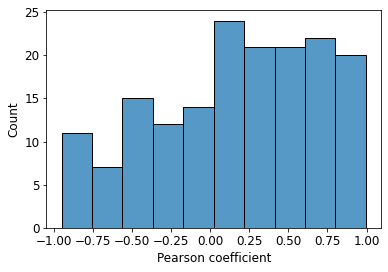

In [44]:
sns.histplot(data = ordered_df["Pearson coefficient"], bins = 10)
plt.savefig("pearson_random_forest.eps", format = 'eps', dpi=300)


Let's try to do a bit of hyperparameter tuning to check for the best hyperparameters for random forest. 

In [45]:
def rf_training(xs, y, test_df, n_estimators=100, max_samples=300,
       max_features=0.5, min_samples_leaf=5, random_state = 42, **kwargs):
   m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf,random_state = random_state , 
        oob_score=True)
   m.fit(xs, y)      
   y_pred = m.predict(valid_xs)
   weighted_pear = wpc_score(test_df, y_pred)
   return weighted_pear

Let's try our function and see if it reproduces previous results.

In [48]:
rf_training(xs, y, test_df)

0.18512969318482886

Close enough, the small difference can be explained by the fact that we didn't fix the random seed. Let's try some hyperparameter tuning.

In [ ]:
n_estimators_list=[100, 200, 300, 400] 
max_samples_list=[10, 20, 50, 100, 150, 200, 300, 400, 500, 600]
max_features_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
min_samples_leaf_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

"We set initial set of hyperparameters and metric"
best_hyperparam = [0,0,0,0]
best_metric = 0
for n_estimators in n_estimators_list:
  for max_samples in max_samples_list:
    for max_features in max_features_list: 
      for min_samples_leaf in min_samples_leaf_list:
        wpc = rf_training(xs, y, test_df, n_estimators=n_estimators, 
                          max_samples=max_samples, max_features=max_features, 
                          min_samples_leaf=min_samples_leaf, random_state = 42)
        if wpc > best_metric:
          best_metric = wpc
          best_hyperparam = [n_estimators, max_samples, max_features, 
                             min_samples_leaf]
        print("Best hyperparameters: ", best_hyperparam)
        print("Best metric", best_metric)


Best hyperparameters:  [100, 10, 0.1, 1]
Best metric 0.06364080851754765
Best hyperparameters:  [100, 10, 0.1, 2]
Best metric 0.0642681732830587
Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523
Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523
Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523
Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523
Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523
Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523
Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523
Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523
Best hyperparameters:  [100, 10, 0.1, 3]
Best metric 0.10758117699481523
Best hyperparameters:  [100, 10, 0.3, 2]
Best metric 0.11255650711357022
Best hyperparameters:  [100, 10, 0.3, 3]
Best metric 0.13021029313518698
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metric 0.18937838542197255
Best hyperparameters:  [100, 10, 0.3, 4]
Best metri

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7,

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7,

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818
Best hyperparameters:  [100, 500, 0.7,

In [ ]:
print("Best hyperparameters: ", best_hyperparam)
print("Best metric", best_metric)

Best hyperparameters:  [100, 500, 0.7, 1]
Best metric 0.22994661776817818


# Tabular learner fastai
As next model we will try a Tabular Learner from FastAI. 
First thing we have to do is normalize the data. We create another TabularPandas object:


In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(df_nocomb, procs, cat, cont, y_names=dep_var, 
                      splits=splits)

Now we create our dataloader and check for the maximum and minimum of our data. This is useful as we will limit the output interval of our model

In [ ]:
dls = to_nn.dataloaders(1024)
y = to_nn.train.y
y.min(),y.max()

(-178.6540985107422, 237.37640380859375)

We create our learner and look for an optimal learning rate with lr_find.

SuggestedLRs(valley=0.0010000000474974513)

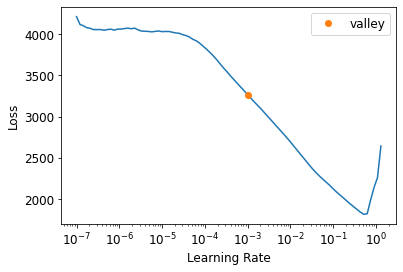

In [ ]:
learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[200,50, 20],
                        n_out=1, loss_func=F.mse_loss)
learn.lr_find()


Now we finetune our learner by a few epochs.



In [ ]:
learn.fit_one_cycle(50, 1e-3)


epoch,train_loss,valid_loss,time
0,4117.541504,1458.527344,00:00
1,4028.859131,1391.474365,00:00
2,3947.213135,1327.601074,00:00
3,3866.347656,1264.543091,00:00
4,3689.180908,1205.392090,00:00
5,3536.247314,1150.564453,00:00
6,3368.241211,1101.905273,00:00
7,3209.256348,1057.416626,00:00
8,3061.905518,1017.447632,00:00
9,2943.799072,981.191895,00:00


Lastly, we obtain our predictions and compute the WPC metric. Since the FastAI learner outputs a tensor, we have to Flatten it.


In [ ]:
y_pred, targs = learn.get_preds()
y_pred = np.asarray(y_pred[:,0])
wpc_score(test_df, y_pred)


0.10968063703535985

In [ ]:
weighted_pear, pear_weights_df = nan_weighted_pearson(test_df, y_pred)
print("Weighted Pearson: ", weighted_pear)
print(pear_weights_df)

Weighted Pearson:  0.10968063703535985
      Combination ID  n_cl  Pearson coefficient
0          EGFR.FGFR     6             0.727809
1        FASN.MTOR_1     7             0.467770
2         IAP.IGFR_3     3            -0.944783
3        FGFR.MTOR_3     5             0.505273
4         IAP.PIK3CB    10             0.643841
..               ...   ...                  ...
162   Cisplatin.FGFR     3             0.678983
163      HSP90.PIK3C     3            -0.456856
164  ATM.Gemcitabine     3             0.647182
165     ATR_4.HDAC_4     3             0.328268
166   BCL2.CSNK2A1_2     6             0.292057

[167 rows x 3 columns]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

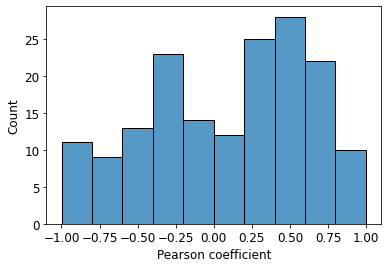

In [ ]:
sns.histplot(data = pear_weights_df["Pearson coefficient"], bins = 10)
plt.savefig("pearson_tabular_learner.eps", format = 'eps', dpi=300)

# Ensemble: Tabular Learner + Random Forest.

We will average predictions between Tabular Learner and Random Forest to create a superior model.

In [49]:
"Random Forest"
m_rf = rf(xs, y, n_estimators=100, max_samples=500,
       max_features=0.7, min_samples_leaf=1 );
y_pred_rf = m_rf.predict(valid_xs)
wpc_score(test_df, y_pred_rf)


0.21596847115054565

SuggestedLRs(valley=0.0014454397605732083)

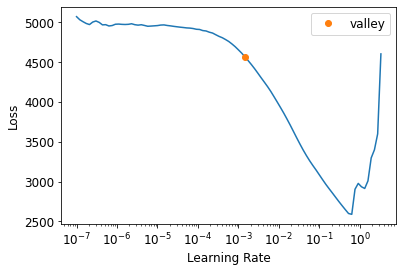

In [57]:
"Tabular learner"
procs_nn = [Categorify, FillMissing, Normalize]
"For some reason the prediction improves when I don't normalize"
"so I will use procs instead of procs_nn"
to_nn = TabularPandas(df_nocomb, procs_nn, cat, cont, y_names=dep_var, 
                      splits=splits)
dls = to_nn.dataloaders(1024)
y = to_nn.train.y
y.min(),y.max()
learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[30,20, 10],
                        n_out=1, loss_func=F.mse_loss)
learn.lr_find()


epoch,train_loss,valid_loss,time
0,1208.739624,1646.911377,00:00
1,1180.287842,1647.380371,00:00
2,1171.512817,1644.579956,00:00
3,1170.510254,1641.880981,00:00
4,1182.001587,1641.914917,00:00
5,1189.290527,1641.895874,00:00
6,1198.275879,1642.931885,00:00
7,1195.511963,1638.089966,00:00
8,1185.079102,1632.081909,00:00
9,1183.996826,1622.902222,00:00


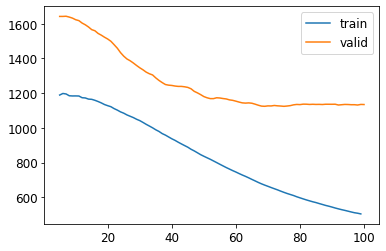

In [60]:
learn.fit_one_cycle(100, 0.001)
learn.recorder.plot_loss()

In [61]:
y_pred_nn, targs = learn.get_preds()
y_pred_nn = np.asarray(y_pred_nn[:,0])
wpc_score(test_df, y_pred_nn)

0.1609991074516762

epoch,train_loss,valid_loss,time
0,338.131897,1134.851562,00:00
1,334.190613,1136.364014,00:00
2,342.318848,1139.981323,00:00
3,346.664673,1138.848877,00:00
4,349.630859,1138.807129,00:00
5,347.499237,1135.926392,00:00
6,343.709808,1131.809937,00:00
7,347.490662,1129.888184,00:00
8,347.826599,1129.991821,00:00
9,349.016266,1126.678833,00:00


0.15353115962221955

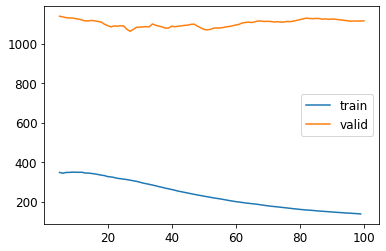

In [62]:
learn.fit_one_cycle(100, 0.001)
learn.recorder.plot_loss()
y_pred_nn_2, targs = learn.get_preds()
y_pred_nn_2 = np.asarray(y_pred_nn_2[:,0])
wpc_score(test_df, y_pred_nn_2)

We save the model

In [ ]:
# learn.save("/content/gdrive/MyDrive/archivos_tfm/tabular_model")

Path('/content/gdrive/MyDrive/archivos_tfm/tabular_model.pth')

Let's try to load it and see if it works

In [ ]:
learn_load = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[30,20, 10],
                        n_out=1, loss_func=F.mse_loss)

learn_load.load("/content/gdrive/MyDrive/archivos_tfm/tabular_model")

y_pred_nn_2, targs = learn_load.get_preds()
y_pred_nn_2 = np.asarray(y_pred_nn_2[:,0])
wpc_score(test_df, y_pred_nn_2)

0.2154470781567858

All together:

In [63]:
y_pred_avg = (y_pred_rf + y_pred_nn_2 )/ 2
wpc_score(test_df, y_pred_avg)

0.192401247389817

Depending on the run it improves the metric marginally or it even decreases.

# XGBOOST

Out of curiosity, let's try XGBoost and ensemble it.

In [64]:
m_xgb = XGBRegressor(n_estimators=200, max_depth=7, eta=0.1, 
                     subsample=0.7, colsample_bytree=0.8, random_state = 42)
m_xgb.fit(xs, y)
y_pred_xgb = m_xgb.predict(valid_xs)
wpc_score(test_df, y_pred_xgb)


[19:02:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.21096142884429614

WPC = 0.21 without any hyperparameter tuning. Now we ensemble the 3 of them:
Random Forest + XGBoost + Neural Networks.

In [66]:
y_pred_avg = (y_pred_rf + y_pred_nn_2 + y_pred_xgb)/ 3
wpc_score(test_df, y_pred_avg)

0.22880674589628094

And only Random Forest and XGBoost

In [67]:
y_pred_avg = (y_pred_rf +  y_pred_xgb)/ 2
wpc_score(test_df, y_pred_avg)

0.22336154442854125

# Support Vector Regressor

In [68]:
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(df_nocomb, procs_nn, cat, cont, y_names=dep_var, 
                      splits=splits)


In [69]:
m_SVR = SVR(kernel="linear")
m_SVR.fit(to_nn.train.xs, to_nn.train.y)
y_pred_SVR = m_SVR.predict(to_nn.valid.xs)

wpc_score(test_df, y_pred_SVR)

0.129339352426828

Now we ensemble the 4 of them:
Random Forest + XGBoost + Neural Networks + SVM

In [72]:
y_pred_avg = (y_pred_rf + y_pred_nn_2 + y_pred_xgb + y_pred_SVR)/ 4
wpc_score(test_df, y_pred_avg)

0.23113931643817118

The improvement is only marginal. 

## Feature importance

In [73]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m_rf, xs)
fi[:10]

,cols,imp
0,Cell line name,0.115452
11,Einf A,0.107123
13,H B,0.100455
9,IC50 A,0.100249
14,Einf B,0.096013
10,H A,0.092841
12,IC50 B,0.079285
1,Compound A,0.064230
2,Compound B,0.057717
6,Pathway_drug_B,0.043892


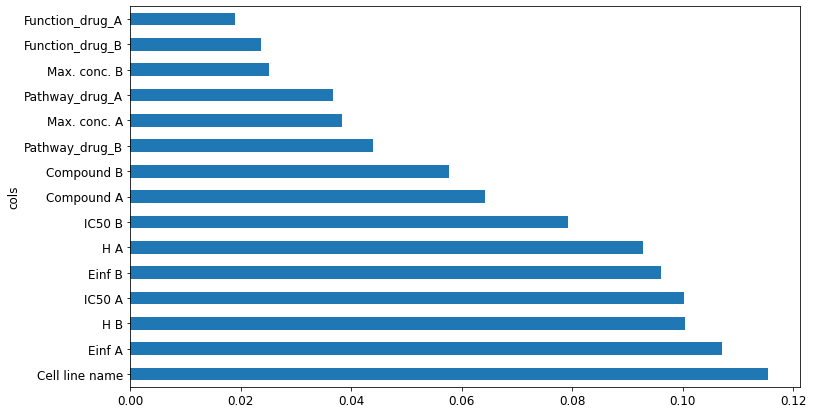

In [74]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:]);

Here we don't have a lot of columns, so we don't have
to erase any of them.

We realize that adding drug information doesn't improve predictions and that it's not an important category.